In [1]:
from pylab import *
%matplotlib inline

In [2]:
def rk4(ec,p_ini,x,args=0,h=0.01):  
    if (x[1]-x[0]) <= 5*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    return tiempos,sol

In [3]:
def e_mov(r_v,t,fric=0,g=9.8,m=1):
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-(g/m)
        #print "No use un modelo de friccion"
    else:
        dvx = - fric([r_v[2],r_v[3]])[0]
        dvy = -(g/m) - fric([r_v[2],r_v[3]])[1]
        #print "Use un modelo de friccion"
    return array([dx,dy,dvx,dvy])

In [4]:
def fric_v(v,gamma=0.1): # la fricción con el aire es proporcional a la velocidad.
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

def fric_v2(v,gamma=0.1): # la fracción es proporcional al cuadrado de la velocidad
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y = gamma*norm_v*v[1]
    return array([f_x,f_y]) 

In [23]:
def rebote(r_v_i,mi_dt,fric):
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > abs(plano): # es esta parte si abs(y_izq[1]) esta por arriba del plano inclinado entra 
                                     # al ciclo, este es el unico cambio que se le hizo a este algoritmo
    
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]
      
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
    return y_izq


In [24]:
def rebote2(r_v_i,mi_dt,fric):
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[0]) > 10: # es esta parte si abs(y_izq[1]) esta por arriba del plano inclinado entra 
       
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]
       
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])    
    return y_izq

In [25]:
def rebote3(r_v_i,mi_dt,fric):
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[0]) < 0: # es esta parte si abs(y_izq[1]) esta por arriba del plano inclinado entra  
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]
       
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])    
    return y_izq

In [26]:
def rebote4(r_v_i,mi_dt,fric):
    dt_busqueda = (mi_dt)/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > 5.9: # es esta parte si abs(y_izq[1]) esta por arriba del plano inclinado entra  
        reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric)
        y_izq = reinicio
        y_med = sol[-1,:]
      
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
    return y_izq

In [27]:
def pendiente(angulo): # encuentra la pendiente en funcion del angulo dado
    m = -tan(angulo)
    return m 
def f(x,angulo,h):     # encuentra la recta del plano en funcion del angulo, p es la altura inicial
    if abs(x) <= 5:
        y=x*pendiente(angulo)+h
    else:
        y=-x*pendiente(angulo)-h   
    return y

In [28]:
def g(x,angulo):     # encuentra la recta del plano en funcion del angulo, p es la altura inicial
    f=x*pendiente(angulo)+2.8867513459481287
    return f
def k(z,angulo):
    f=-z*pendiente(angulo)-2.8867513459481287   
    return f

rebotes = 22


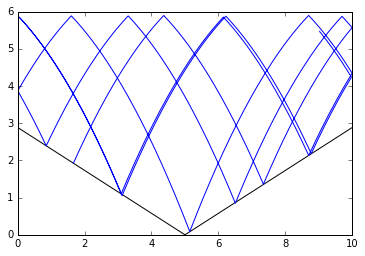

In [29]:
fric = 0
r = 0
a=(pi/6) # angulo de inclinacion del plano
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,5,10] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 1000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 1664


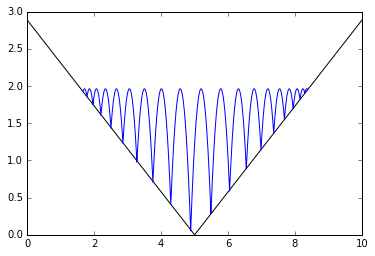

In [30]:
fric = 0
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(a)
v_x = sin(a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 2235


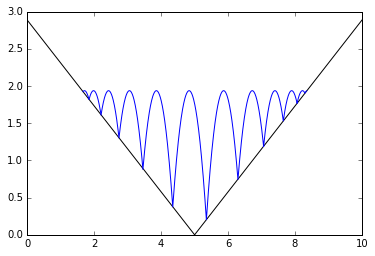

In [31]:
fric=0 
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(2*a)
v_x = sin(2*a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 2340


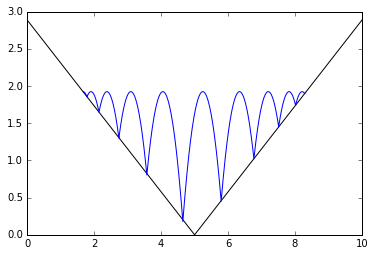

In [32]:
fric=0 
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(3*a)
v_x = sin(3*a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 192


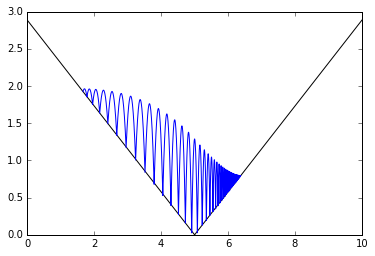

In [15]:
fric = fric_v
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(a)
v_x = sin(a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 1944


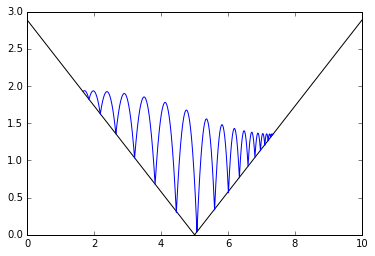

In [33]:
fric = fric_v
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(2*a)
v_x = sin(2*a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 2136


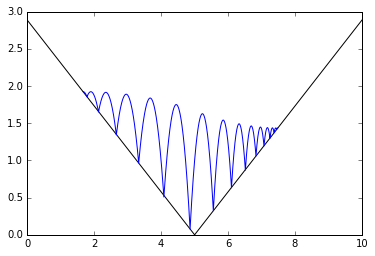

In [34]:
fric = fric_v
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(3*a)
v_x = sin(3*a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 58


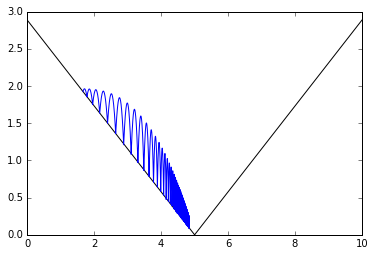

In [35]:
fric = fric_v2
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(a)
v_x = sin(a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 1659


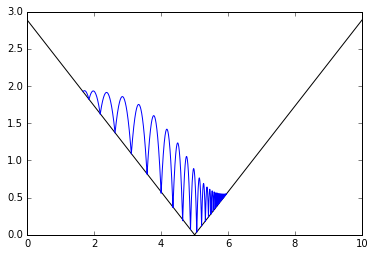

In [36]:
fric = fric_v2
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(2*a)
v_x = sin(2*a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 1943


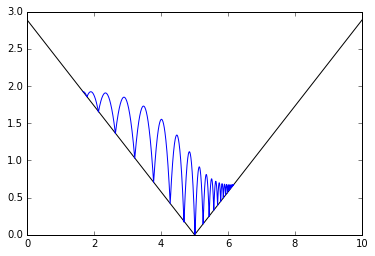

In [37]:
fric = fric_v2
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(3*a)
v_x = sin(3*a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 3000 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
x=linspace(0,5)
z=linspace(5,10)
plot(x,g(x,a),'black',z,k(z,a),'black')
plot(trayectoria[:,0],trayectoria[:,1],'-') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 19


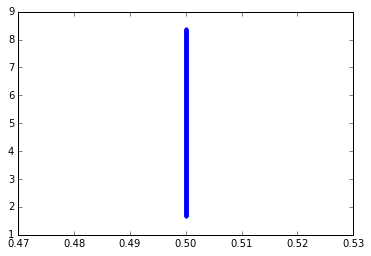

In [38]:
fric = 0
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(a)
v_x = sin(a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 1350 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
plot(trayectoria[:,2],trayectoria[:,0],'.') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()

rebotes = 9


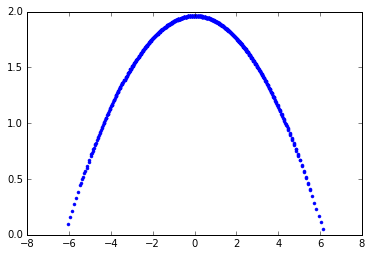

In [39]:
fric = 0
r = 0
a=(pi/6) # angulo de inclinacion del plano
v_y = cos(a)
v_x = sin(a) 
h = -f(5,a,0)
x_in = 5./3.
y_in = f(x_in,a,h) # altura de la pendiente desde donde se hace el lazamiento
inicio = [x_in,y_in,v_x,v_y] # las dos primeras entradas corresponden a la posicion inicial de la pelora (x,y)
                    # las ultimas dos estradas corresponde a las componetes de la velocidad incial de la pelota (vx,vy) 
N = 700 # numero de puntos a calcular dentro de la trayectoria
trayectoria = zeros((N,len(inicio)))
mi_dt = .01
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric) # aqui se escoje la friccion a utilizar
    plano = f(sol_dt[-1,:][0],a,h) # utiliza la funcion de la recta para encontrar el punto donde la pelota rebota
    if sol_dt[-1,:][1] < plano: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]      
    if sol_dt[-1,:][1] > 5.9: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote4(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
    if sol_dt[-1,:][0] > 10: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote2(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto 
        r +=1
    if sol_dt[-1,:][0] < 0: # si la posicion en y de la pelota es menor a la altura del plano la pelota rebota
        punto = rebote3(trayectoria[i,:],mi_dt,fric)
        trayectoria[i+1,:] = punto
        r +=1
plot(trayectoria[:,3],trayectoria[:,1],'.') # grafica los punto de la trayectoria 
print "rebotes =",r                                                        # y el plano donde rebota la pelota
show()